In [1]:
import torch
import torch.nn as nn
import math
import torch.utils.model_zoo as model_zoo
import torch.nn.functional as F 
 
__all__ = ['ResNet', 'resnet18_cbam', 'resnet34_cbam', 'resnet50_cbam', 'resnet101_cbam',
           'resnet152_cbam']
 
 
model_urls = {
    'resnet18': 'https://download.pytorch.org/models/resnet18-5c106cde.pth',
    'resnet34': 'https://download.pytorch.org/models/resnet34-333f7ec4.pth',
    'resnet50': 'https://download.pytorch.org/models/resnet50-19c8e357.pth',
    'resnet101': 'https://download.pytorch.org/models/resnet101-5d3b4d8f.pth',
    'resnet152': 'https://download.pytorch.org/models/resnet152-b121ed2d.pth',
}
 
 
def conv3x3(in_planes, out_planes, stride=1):
    "3x3 convolution with padding"
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False,dilation=1)
 
class ChannelAttention(nn.Module):
    def __init__(self, in_planes, ratio=16):
        super(ChannelAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)
           
        self.fc = nn.Sequential(nn.Conv2d(in_planes, in_planes // 16, 1, bias=False),
                               nn.ReLU(),
                               nn.Conv2d(in_planes // 16, in_planes, 1, bias=False))
        self.sigmoid = nn.Sigmoid()
 
    def forward(self, x):
        avg_out = self.fc(self.avg_pool(x))
        max_out = self.fc(self.max_pool(x))
        out = avg_out + max_out
        return self.sigmoid(out)
 
class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()
 
        self.conv1 = nn.Conv2d(2, 1, kernel_size, padding=kernel_size//2, bias=False)
        self.sigmoid = nn.Sigmoid()
 
    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        x = torch.cat([avg_out, max_out], dim=1)
        x = self.conv1(x)
        return self.sigmoid(x)
 
class BasicBlock(nn.Module):
    expansion = 1
 
    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)

 
        self.downsample = downsample
        self.stride = stride
 
    def forward(self, x):
        residual = x
 
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
 
        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)
 
        out += residual
        out = self.relu(out)
 
        return out

class BasicBlock_CBAM(nn.Module):
    expansion = 1
 
    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock_CBAM, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
 
        self.ca = ChannelAttention(planes)
        self.sa = SpatialAttention()
 
        self.downsample = downsample
        self.stride = stride
 
    def forward(self, x):
        residual = x
 
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
 
        out = self.conv2(out)
        out = self.bn2(out)
 
        out = self.ca(out) * out
        out = self.sa(out) * out
 
        if self.downsample is not None:
            residual = self.downsample(x)
 
        out += residual
        out = self.relu(out)
 
        return out    

 
class Bottleneck(nn.Module):
    expansion = 4
 
    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, planes * 4, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * 4)
        self.relu = nn.ReLU(inplace=True)
 
        self.ca = ChannelAttention(planes * 4)
        self.sa = SpatialAttention()
 
        self.downsample = downsample
        self.stride = stride
 
    def forward(self, x):
        residual = x
 
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
 
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)
 
        out = self.conv3(out)
        out = self.bn3(out)
 
        out = self.ca(out) * out
        out = self.sa(out) * out
 
        if self.downsample is not None:
            residual = self.downsample(x)
 
        out += residual
        out = self.relu(out)
 
        return out
 
 
class ResNet(nn.Module):
 
    def __init__(self, block, layers, num_classes=22): # 类别数量
        self.inplanes = 64
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(Bottleneck, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(BasicBlock_CBAM, 512, layers[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)
        self.softmax = nn.LogSoftmax(dim=-1)
 
        for m in self.modules():
            if isinstance(m, nn.Conv2d): 
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
 
    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )
 
        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))
 
        return nn.Sequential(*layers)
 
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
 
        x = self.layer1(x)    
        x = self.layer2(x)

        feature = x
       
        x = self.layer3(x)
        x = self.layer4(x)

        #假如你要可视化某一层的特征图，则需要将该层的特征图返回出来，因此需要先修改网络中的forward函数。具体修改方式如下所示。
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        x = self.softmax(x)
        return x
        #return feature,x
  
def resnet18_cbam(pretrained=False, **kwargs):
    """Constructs a ResNet-18 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNet(BasicBlock, [2, 2, 2, 2], **kwargs)
    if pretrained:
        pretrained_state_dict = model_zoo.load_url(model_urls['resnet18'])
        now_state_dict        = model.state_dict()
        now_state_dict.update(pretrained_state_dict)
        model.load_state_dict(now_state_dict)
    return model

100%|██████████| 16/16 [00:09<00:00,  1.70it/s]


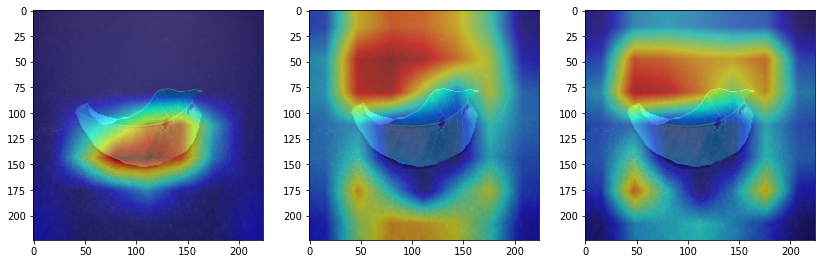

In [9]:
# 官方指导代码
from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad,DeepFeatureFactorization
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget,ClassifierOutputSoftmaxTarget
from pytorch_grad_cam.utils.image import show_cam_on_image,preprocess_image
from torchvision.models import resnet50
import numpy as np
import cv2
from matplotlib.pylab import plt

model = resnet18_cbam(pretrained=False)
model.load_state_dict(torch.load('D:\\Data\\model2.pth'))
#model = model.cuda().eval()
model = model.cpu().eval()

target_layers = [model.layer4[0]]

image_path = "D:\\Data\\Gauva_diseased.JPG"

img = cv2.imread(image_path, 1)
img = np.float32(cv2.resize(img, (224, 224))) / 255
input = preprocess_image(img)

input_tensor = input# Create an input tensor image for your model..
# Note: input_tensor can be a batch tensor with several images!

# Construct the CAM object once, and then re-use it on many images:
Gcam = GradCAM(model=model, target_layers=target_layers, use_cuda=False)
Acam = AblationCAM(model=model, target_layers=target_layers, use_cuda=False)
Scam = ScoreCAM(model=model, target_layers=target_layers, use_cuda=False)
Hcam = HiResCAM(model=model, target_layers=target_layers, use_cuda=False)
# You can also use it within a with statement, to make sure it is freed,
# In case you need to re-create it inside an outer loop:
# with GradCAM(model=model, target_layers=target_layers, use_cuda=args.use_cuda) as cam:
#   ...

# We have to specify the target we want to generate
# the Class Activation Maps for.
# If targets is None, the highest scoring category
# will be used for every image in the batch.
# Here we use ClassifierOutputTarget, but you can define your own custom targets
# That are, for example, combinations of categories, or specific outputs in a non standard model.

targets = [ClassifierOutputSoftmaxTarget(0)]

# You can also pass aug_smooth=True and eigen_smooth=True, to apply smoothing.
grayscale_camG = Gcam(input_tensor=input_tensor, targets=targets,aug_smooth=True,eigen_smooth=True)
grayscale_camA = Acam(input_tensor=input_tensor, targets=targets,aug_smooth=True,eigen_smooth=True)
# grayscale_camS = Scam(input_tensor=input_tensor, targets=targets,aug_smooth=True,eigen_smooth=True)
grayscale_camH = Hcam(input_tensor=input_tensor, targets=targets,aug_smooth=True,eigen_smooth=True)
plt.figure(figsize=(14,6))
# In this example grayscale_cam has only one image in the batch:
grayscale_camG = grayscale_camG[0, :]
grayscale_camA = grayscale_camA[0, :]
# grayscale_camS = grayscale_camS[0, :]
grayscale_camH = grayscale_camH[0, :]

GradCAM_visualization = show_cam_on_image(img, grayscale_camG, use_rgb=True)
AblationCAM_visualization = show_cam_on_image(img, grayscale_camA, use_rgb=True)
# ScoreCAM_visualization = show_cam_on_image(img, grayscale_camS, use_rgb=True)
HiResCAM_visualization = show_cam_on_image(img, grayscale_camH, use_rgb=True)

plt.subplot(1, 3, 1)
plt.imshow(GradCAM_visualization)
plt.subplot(1, 3, 2)
plt.imshow(AblationCAM_visualization)
plt.subplot(1, 3, 3)
plt.imshow(HiResCAM_visualization)
plt.savefig("D://CAM.tif",dpi=200)

In [30]:
from pytorch_grad_cam.utils.model_targets import ClassifierOutputSoftmaxTarget
from pytorch_grad_cam.metrics.cam_mult_image import CamMultImageConfidenceChange
from pytorch_grad_cam.metrics.road import ROADMostRelevantFirstAverage,ROADLeastRelevantFirstAverage,ROADCombined
from pytorch_grad_cam.utils.image import show_cam_on_image,preprocess_image,deprocess_image

# Create the metric target, often the confidence drop in a score of some category
metric_target = ClassifierOutputSoftmaxTarget(22)
scores, batch_visualizations = CamMultImageConfidenceChange()(input_tensor, inverse_cams, targets, model, return_visualization=True)
visualization = deprocess_image(batch_visualizations[0, :])

# State of the art metric: Remove and Debias
from pytorch_grad_cam.metrics.road import ROADMostRelevantFirst, ROADLeastRelevantFirst
cam_metric = ROADMostRelevantFirst(percentile=75)
scores, perturbation_visualizations = cam_metric(input_tensor,grayscale_cams, targets, model, return_visualization=True)

# You can also average accross different percentiles, and combine
# (LeastRelevantFirst - MostRelevantFirst) / 2

cam_metric = ROADCombined(percentiles=[20, 40, 60, 80])
scores = cam_metric(input_tensor, grayscale_cams, targets, model)

NameError: name 'inverse_cams' is not defined